In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.colors import LogNorm
from tqdm import tqdm

from infovar import MI, LinearInfo, LinearInfoLog10, LinearInfoGauss

plt.rc("text", usetex=True)

mu = -0.5 * np.log(2) * np.ones((2,))
sigma = np.array([
    [np.log(2), np.log(1.9)],
    [np.log(1.9), np.log(2)]
])

def sample_multivariate_lognormal(size, mu, sigma):
    return np.exp(stats.multivariate_normal(mu, sigma).rvs(size))
    # return stats.multivariate_normal(mu, sigma).rvs(size)

In [2]:
n_samples = 10_000

data = sample_multivariate_lognormal(n_samples, mu, sigma)
x, y = data[:, 0].reshape(-1, 1), data[:, 1].reshape(-1, 1)

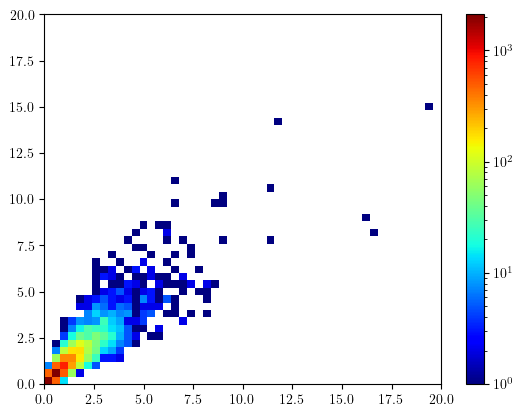

In [3]:
plt.hist2d(x.flatten(), y.flatten(), bins=50, range=((0, 20), (0, 20)), norm=LogNorm(), cmap="jet");
plt.colorbar()
plt.show()

In [4]:
mi_op = MI()
lininfo_op = LinearInfo()
lininfolog_op = LinearInfoLog10()
lininfogauss_op = LinearInfoGauss()

## Error bars

In [5]:
n_iters = 100
n_samples = 10_000

mis = []
lininfos = []
lininfologs = []
lininfogauss = []
for it in range(n_iters):
    data = sample_multivariate_lognormal(n_samples, mu, sigma)
    x, y = data[:, 0].reshape(-1, 1), data[:, 1].reshape(-1, 1)

    mis.append(mi_op(x, y))
    lininfos.append(lininfo_op(x, y))
    lininfologs.append(lininfolog_op(x, y))
    lininfogauss.append(lininfogauss_op(x, y))

In [6]:
mi_mean = np.mean(mis)
lininfo_mean = np.mean(lininfos)
lininfolog_mean = np.mean(lininfologs)
lininfogauss_mean = np.mean(lininfogauss)

mi_sigma = np.std(mis)
lininfo_sigma = np.std(lininfos)
lininfolog_sigma = np.std(lininfologs)
lininfogauss_sigma = np.std(lininfogauss)

mi_th = 1.4053561578384077

In [7]:
fontsize = 14
labelsize = 14

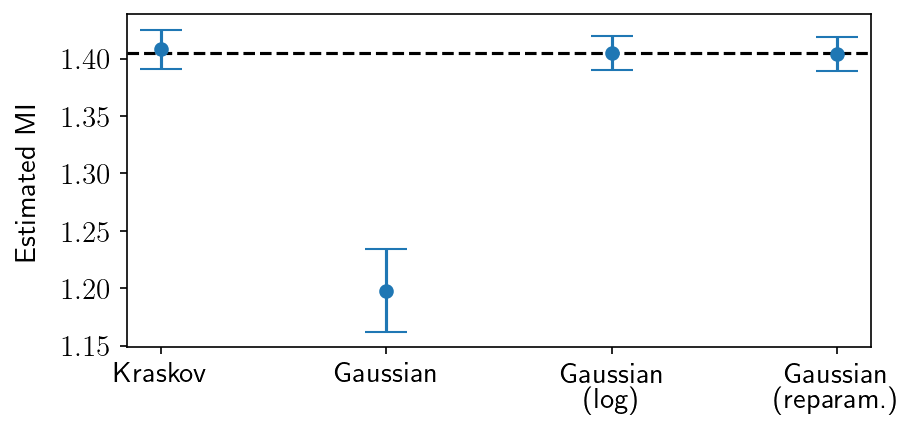

In [8]:
vals = [mi_mean, lininfo_mean, lininfolog_mean, lininfogauss_mean]
bars = [mi_sigma, lininfo_sigma, lininfolog_sigma, lininfogauss_sigma]

plt.figure(figsize=(6.4, 0.6*4.8), dpi=150)

ticks = np.arange(4)
plt.errorbar(ticks, vals, yerr=bars, fmt="o", capsize=10)
plt.xticks(ticks, ["Kraskov", "Gaussian", "Gaussian\\\\\\phantom{aaaii}(log)", "Gaussian\\\\\\phantom{ai}(reparam.)"], rotation=0, fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.axhline(mi_th, color="black", linestyle="--", label="Theoretical value")

plt.ylabel("Estimated MI", fontsize=labelsize, labelpad=10)

# plt.savefig("estimators-comparison", bbox_inches="tight")
plt.show()

In [9]:
bars

[0.017199595566233777,
 0.035963430548769444,
 0.014800302450569165,
 0.014715368127438119]

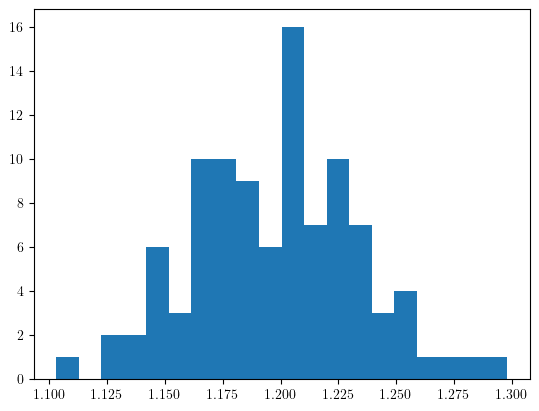

In [10]:
plt.hist(lininfos, bins=20)
plt.show()

## Impact of the sample size

In [11]:
def set_iters(n: int) -> int:
    if n < 200:
        return 1_000 # 10_000
    if n < 1_000:
        return 1_000
    if n < 10_000:
        return 100
    return 20

n_points = 100
samples = np.logspace(1, 5, n_points).round().astype(int)
n_iters = np.array([set_iters(n) for n in samples])

mis = []
lininfos = []
lininfologs = []
lininfogauss = []
for n, iters in tqdm(zip(samples, n_iters), total=n_points):
    _mis = []
    _lininfos = []
    _lininfologs = []
    _lininfogauss = []
    for it in range(iters):
        data = sample_multivariate_lognormal(n, mu, sigma)
        x, y = data[:, 0].reshape(-1, 1), data[:, 1].reshape(-1, 1)

        _mis.append(mi_op(x, y))
        _lininfos.append(lininfo_op(x, y))
        _lininfologs.append(lininfolog_op(x, y))
        _lininfogauss.append(lininfogauss_op(x, y))

    mis.append(_mis)
    lininfos.append(_lininfos)
    lininfologs.append(_lininfologs)
    lininfogauss.append(_lininfogauss)

  1%|          | 1/100 [00:02<03:21,  2.04s/it]/users/astro/einig/Python/infovar/infovar/stats/info_theory.py:23: RuntimeWarning: divide by zero encountered in log
  return - 0.5 * np.log(1 - rho**2) / np.log(base)
/users/astro/einig/Python/infovar/infovar/stats/info_theory.py:23: RuntimeWarning: divide by zero encountered in log
  return - 0.5 * np.log(1 - rho**2) / np.log(base)
/users/astro/einig/Python/infovar/infovar/stats/info_theory.py:23: RuntimeWarning: divide by zero encountered in log
  return - 0.5 * np.log(1 - rho**2) / np.log(base)
  2%|▏         | 2/100 [00:04<03:19,  2.04s/it]/users/astro/einig/Python/infovar/infovar/stats/info_theory.py:23: RuntimeWarning: invalid value encountered in log
  return - 0.5 * np.log(1 - rho**2) / np.log(base)
/users/astro/einig/Python/infovar/infovar/stats/info_theory.py:23: RuntimeWarning: invalid value encountered in log
  return - 0.5 * np.log(1 - rho**2) / np.log(base)
100%|██████████| 100/100 [05:01<00:00,  3.01s/it]


/users/astro/einig/Python/informative-obs-paper/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


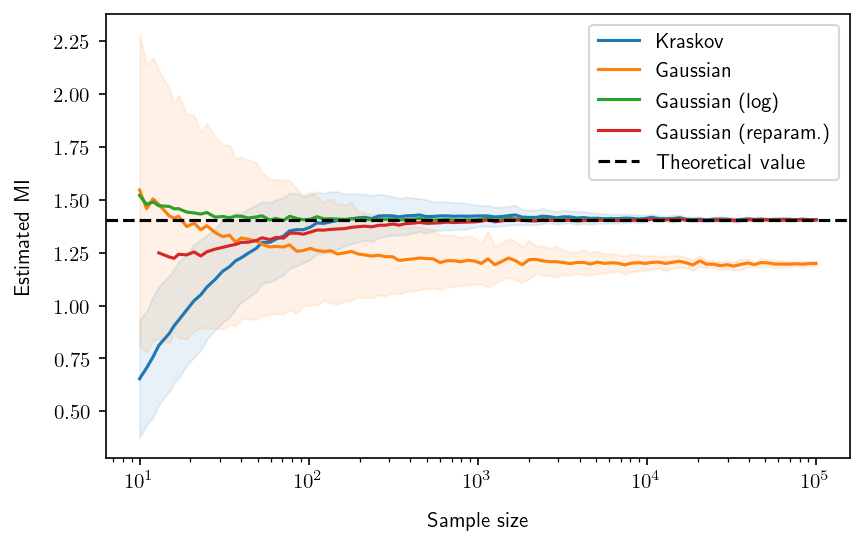

In [12]:
plt.figure(figsize=(6.4, 0.8*4.8), dpi=150)

_mu, _sigma = np.array([np.mean(arr) for arr in mis]), np.array([np.std(arr) for arr in mis])
plt.plot(samples, _mu, label="Kraskov")
plt.fill_between(samples, (_mu-_sigma), (_mu+_sigma), color='tab:blue', alpha=.1)

_mu, _sigma = np.array([np.mean(arr) for arr in lininfos]), np.array([np.std(arr) for arr in lininfos])
plt.plot(samples, _mu, label="Gaussian")
plt.fill_between(samples, (_mu-_sigma), (_mu+_sigma), color='tab:orange', alpha=.1)

_mu, _sigma = np.array([np.mean(arr) for arr in lininfologs]), np.array([np.std(arr) for arr in lininfologs])
plt.plot(samples, _mu, label="Gaussian (log)")
# plt.fill_between(samples, (_mu-_sigma), (_mu+_sigma), color='tab:green', alpha=.1)

_mu, _sigma = np.array([np.mean(arr) for arr in lininfogauss]), np.array([np.std(arr) for arr in lininfogauss])
plt.plot(samples, _mu, label="Gaussian (reparam.)")
# plt.fill_between(samples, (_mu-_sigma), (_mu+_sigma), color='tab:red', alpha=.1)

plt.xscale("log")

plt.axhline(mi_th, color="black", linestyle="--", label="Theoretical value")

plt.xlabel("Sample size", labelpad=10)
plt.ylabel("Estimated MI", labelpad=10)
plt.legend()

# plt.savefig("estimators-comparison-2.png", bbox_inches="tight")
plt.show()

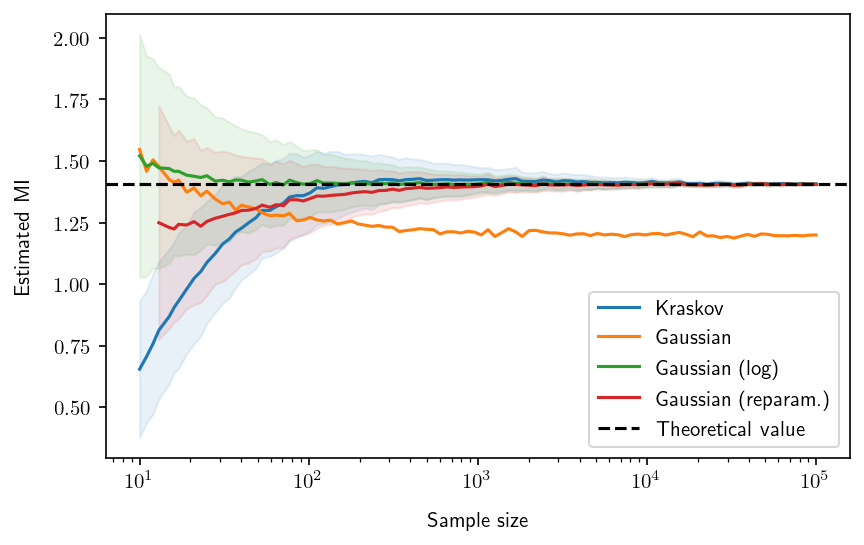

In [18]:
plt.figure(figsize=(6.4, 0.8*4.8), dpi=150)

_mu, _sigma = np.array([np.mean(arr) for arr in mis]), np.array([np.std(arr) for arr in mis])
plt.plot(samples, _mu, label="Kraskov")
plt.fill_between(samples, (_mu-_sigma), (_mu+_sigma), color='tab:blue', alpha=.1)

_mu, _sigma = np.array([np.mean(arr) for arr in lininfos]), np.array([np.std(arr) for arr in lininfos])
plt.plot(samples, _mu, label="Gaussian")
# plt.fill_between(samples, (_mu-_sigma), (_mu+_sigma), color='tab:orange', alpha=.1)

_mu, _sigma = np.array([np.mean(arr) for arr in lininfologs]), np.array([np.std(arr) for arr in lininfologs])
plt.plot(samples, _mu, label="Gaussian (log)")
plt.fill_between(samples, (_mu-_sigma), (_mu+_sigma), color='tab:green', alpha=.1)

_mu, _sigma = np.array([np.mean(arr) for arr in lininfogauss]), np.array([np.std(arr) for arr in lininfogauss])
_sigma[0] = np.nan
plt.plot(samples, _mu, label="Gaussian (reparam.)")
plt.fill_between(samples, (_mu-_sigma), (_mu+_sigma), color='tab:red', alpha=.1)

plt.xscale("log")

plt.axhline(mi_th, color="black", linestyle="--", label="Theoretical value")

plt.xlabel("Sample size", labelpad=10)
plt.ylabel("Estimated MI", labelpad=10)
plt.legend(loc="lower right")

# plt.savefig("estimators-comparison-2-full.png", bbox_inches="tight")
plt.show()